## This notebook uses

https://gitlab.com/ska-telescope/pst/ska-pst/-/blob/main/notebooks/dpd-stat-example.ipynb

as a template. Some functionality might migrate do DAL in the furture as stated.

## Getting PST lib installed

In [26]:
import sys
# remember to add a proper username and passwd to be able to install this in a notebook
!{sys.executable} -m pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple git+https://gitlab.com/ska-telescope/pst/ska-pst

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Cloning https://gitlab.com/ska-telescope/pst/ska-pst to /tmp/pip-req-build-aucptu_u
  Running command git clone --filter=blob:none --quiet https://gitlab.com/ska-telescope/pst/ska-pst /tmp/pip-req-build-aucptu_u
  Resolved https://gitlab.com/ska-telescope/pst/ska-pst to commit e5b648799441f462c92d01140e93e5710aa62c1d
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [27]:
from ska_pst.stat import Statistics

In [28]:
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt

In [29]:
from typing import Tuple

In [30]:
pcap_stat_file_name = "/mnt/cnic-data/pcap/kerr/5453/stat/2025-01-25-20:26:09_0000000000000000_000000.h5"

In [31]:
stats = Statistics.load_from_file(pcap_stat_file_name)

## Atomated testing relevant part

In [54]:
print(stats.header)

                               Key                   Value
0              File Format Version                   1.0.0
1               Execution Block ID  eb-usc7-20250125-7bybb
2                        Telescope                  SKALow
3                          Scan ID                    5453
4                          Beam ID                       1
5                   UTC Start Time     2025-01-25-20:26:09
6                Start Scan Offset                0.559429
7                  End Scan Offset                8.681306
8                  Frequency (MHz)              312.890625
9                  Bandwidth (MHz)                    6.25
10            Start Channel Number                   71928
11              End Channel Number                   73655
12              Num. Polarisations                       2
13                 Num. Dimensions                       2
14                   Num. Channels                    1728
15             Num. Frequency Bins                    17

In [55]:
print(stats.frequency_averaged_stats)

                            Mean          Var.  Clipped
Polarisation Dimension                                 
A            Real      -0.152669  51831.617188        0
             Imag      -0.301569  51755.003906        0
B            Real      -0.152669  51831.617188        0
             Imag      -0.301569  51755.003906        0


In [56]:
print(stats.frequency_averaged_stats_rfi_excised)

                            Mean          Var.  Clipped
Polarisation Dimension                                 
A            Real      -0.152669  51831.617188        0
             Imag      -0.301569  51755.003906        0
B            Real      -0.152669  51831.617188        0
             Imag      -0.301569  51755.003906        0


## For those found of pandas:

In [50]:
samples = stats.metadata.num_samples_spectrum
channel_nums = stats.channel_numbers
df = pd.DataFrame(data={"channel_num": channel_nums, "num_samples": samples})
df

channel_num  num_samples
0           71928        39168
1           71929        39168
2           71930        39168
3           71931        39168
4           71932        39168
...           ...          ...
1723        73651        39168
1724        73652        39168
1725        73653        39168
1726        73654        39168
1727        73655        39168

[1728 rows x 2 columns]

## Fancy plots that are unfortunatelly useless for automated testing

## Display Plots using STAT Data Access Library
The following shows how to do plot data based on the STAT DAL rather than using the HD5F file directly.
The utility methods provided here will be moved to the DAL in the future.

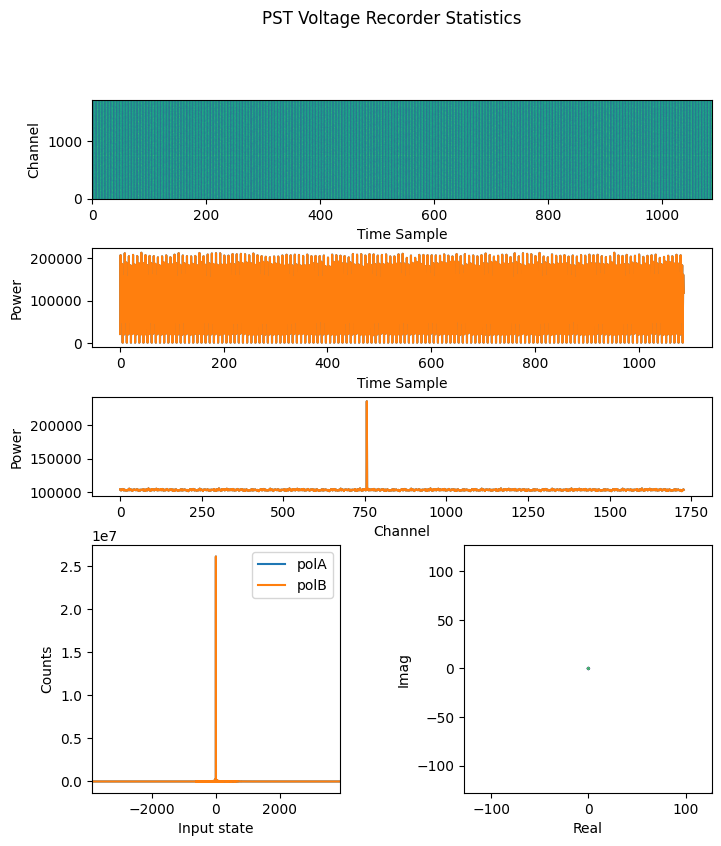

In [52]:
# Spectrogram Plot

fig = plt.figure(figsize=(8, 9))
fig.suptitle("PST Voltage Recorder Statistics")

gs = plt.GridSpec(5, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :])
ax4 = plt.subplot(gs[3:, 0])
ax5 = plt.subplot(gs[3:, 1])

# Spectrogram Plot
spectrogram_pol_a = stats.pol_a_spectrogram
mean = np.mean(spectrogram_pol_a)
stddev = np.std(spectrogram_pol_a)
minval = float(mean - 2.0 * stddev)
maxval = float(mean + 2.0 * stddev)
ax1.imshow(spectrogram_pol_a, origin="lower", vmin=minval, vmax=maxval, aspect="auto")
ax1.set_xlabel("Time Sample")
ax1.set_ylabel("Channel")

# Timeseries Plot
pol_a_timeseries = stats.pol_a_timeseries
pol_b_timeseries = stats.pol_b_timeseries

ax2.plot(pol_a_timeseries["Mean"], label="polA")
ax2.plot(pol_b_timeseries["Mean"], label="polB")
ax2.set_ylabel("Power")
ax2.set_xlabel("Time Sample")

# Spectral Power Plot
pol_a_spectral_power = stats.pol_a_spectral_power
pol_b_spectral_power = stats.pol_b_spectral_power

ax3.plot(pol_a_spectral_power["Mean"], label="polA")
ax3.plot(pol_b_spectral_power["Mean"], label="polB")
ax3.set_xlabel("Channel")
ax3.set_ylabel("Power")

# Histogram
pol_a_real_histogram = stats.pol_a_real_histogram
pol_a_imag_histogram = stats.pol_a_imag_histogram

# find last zero count before any counts


def find_count_bounds(df: pd.DataFrame, column: str = "Count") -> Tuple[int, int]:
    nonzeros = df[df[column] != 0].index
    return (nonzeros[0], nonzeros[-1])  # type: ignore


nbin = stats.metadata.histogram_nbin
pol_a_real_histogram = stats.pol_a_real_histogram
pol_b_real_histogram = stats.pol_b_real_histogram

(pol_a_low_idx, pol_a_high_idx) = find_count_bounds(stats.pol_a_real_histogram)
(pol_b_low_idx, pol_b_high_idx) = find_count_bounds(stats.pol_b_real_histogram)

low_idx = max(0, min(pol_a_low_idx, pol_b_low_idx) - 1)
high_idx = min(nbin - 1, max(pol_a_high_idx, pol_b_high_idx) + 1)
centre_idx = nbin // 2
diff = max(np.abs(centre_idx - low_idx), np.abs(high_idx - centre_idx))
low_idx = max(0, centre_idx - diff)
high_idx = min(nbin - 1, centre_idx + diff)

xbins = np.arange(low_idx, high_idx + 1)
pol_a_real_histogram = pol_a_real_histogram.iloc[xbins]["Count"]  # type: ignore
pol_b_real_histogram = pol_b_real_histogram.iloc[xbins]["Count"]  # type: ignore

xbins = xbins - centre_idx

ax4.set_xlim((xbins[0], xbins[-1]))
ax4.plot(xbins, pol_a_real_histogram, label="polA")
ax4.plot(xbins, pol_b_real_histogram, label="polB")
ax4.set_xlabel("Input state")
ax4.set_ylabel("Counts")
ax4.legend()

# 2D Histogram
pol_a_2d_data = stats.pol_a_rebinned_histogram2d
nrebin = stats.metadata.nrebin
n = nrebin // 2
histogram_bounds = np.arange(-n, n)
ax5.contour(histogram_bounds, histogram_bounds, pol_a_2d_data)
ax5.set_xlabel("Real")
ax5.set_ylabel("Imag")

plt.show()